In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import csv
import os
import sys
import numpy as np
import collections
import time
import scipy
import helpers 
import cPickle as pickle

# CNN bits
import theano
import theano.tensor as T
import lasagne

import helpers
from scipy.misc import imresize
from scipy.ndimage.interpolation import zoom
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import scipy.io.wavfile

# for evaluation
sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import evaluation, features


Using gpu device 0: GeForce GTX 770


In [3]:
# Aim is to do prediction on all the testing files...


In [4]:
datapath = '/home/michael/projects/engaged_hackathon_data/multilabel_classification/'

split = scipy.io.loadmat(datapath + 'split_files.mat')
split['test'] = [xx.strip() for xx in split['test']]

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test, classes = \
    helpers.load_multilabel_dataset(
        datapath + 'all_train.mat', datapath + 'all_test.mat', max_samples=10000)
classes = [cls.strip() for cls in classes]

['split_arrays', 'slices', 'labels', '__header__', '__globals__', '__version__', 'class_names']
['split_arrays', 'slices', 'labels', '__header__', '__globals__', '__version__', 'class_names']


In [6]:
# load in all the test files and convert to spectrograms...
# let's now for each 

all_annotations, annotations_by_file = helpers.load_annotations()

wav_sr = 24000
spec_path = '/home/michael/projects/engaged_hackathon_data/detection/spectrograms/'
wav_base_path = '/home/michael/projects/engaged_hackathon_data/raw_data/one_minute_files'
slices_per_file = 1000
hww = 9
spec_size = 128
test_specs = []

In [7]:
file_length_seconds = 1440008.0 / 24000.0

def test_spec_generator():

    yield_count = 0
    for count, (fname, annotations) in enumerate(annotations_by_file.iteritems()):
        
        if fname not in split['test']:
            continue

        # load in the spectrogram
        D = scipy.io.loadmat(spec_path + fname[:-4] + '_spec_' + str(spec_size) + '.mat')
        spec = D['spectrogram']
        spec_sr = D['sample_rate']
        D['fname'] = fname
        
        labels = collections.defaultdict(lambda : np.zeros(D['wav_shape']))

        for ann in annotations:
            start = int(ann['LabelStartTime_Seconds'] * float(wav_sr))
            end = int(ann['LabelEndTime_Seconds'] * float(wav_sr))
            labels[ann['Label']][start:end] = 1

        # now rescale the locations to the length of the spectrogram...
        # (the spec_sr*60 -1 is a bit of a hack...)
        D['labels'] = labels

        # rescaling the spectrogram to be the same shape as the 
        D['spec_labels'] = collections.defaultdict(lambda: np.zeros(spec_sr*60 - 1))
        for classname, label in labels.iteritems():
            D['spec_labels'][classname] = \
                imresize(label[:, None], size=(spec.shape[1], 1)).ravel() > 0.5

        # add to a structure...
        yield_count += 1
        yield D

In [9]:
wav_results_savedir = '/home/michael/projects/engaged_hackathon_data/multilabel_classification/results/wav/'

# one item in results per test file
results = collections.defaultdict(list)

from sklearn.metrics import accuracy_score

for class_idx, class_name in enumerate(classes):
    
    print "Working on ", class_name
    
    wav_results = {'fp':[], 'fn':[], 'tp':[], 'tn':[]}
    
    modelpath = './models/' + class_name + '.pkl'
    if not os.path.exists(modelpath):
        print "Cannot find model for %s, so skipping" % class_name
        continue
        
    model, predict_fn = pickle.load(open(modelpath))

    # now run on each of the test-time spectrograms...
    for test_file in test_spec_generator():

        # at each location, need to extract a slice...
        spec = test_file['spectrogram']
        patches = features.extract_1d_patches(spec, range(spec.shape[1]), hww)
        
        S = patches.shape
        patches = patches.reshape((S[0], 1, S[1], S[2])).astype(np.float32)
        pred_y = predict_fn(patches)[:, 1]
        gt = test_file['spec_labels'][class_name]
                
        # loading the audio and rescaling
        sr, wav = scipy.io.wavfile.read(wav_base_path + '/25_Random/' + test_file['fname'])
        factor = wav.shape[0] / float(pred_y.shape[0])
        pred_y_rescaled = zoom(pred_y, factor)

        # keep track of the tp fp fn tn wav snippets for saving...
        gt_original = test_file['labels'][class_name]
        wav_results['tp'].append(wav[np.logical_and(gt_original==1, pred_y_rescaled>0.5)])
        wav_results['tn'].append(wav[np.logical_and(gt_original==0, pred_y_rescaled<0.5)])
        wav_results['fp'].append(wav[np.logical_and(gt_original==0, pred_y_rescaled>0.5)])
        wav_results['fn'].append(wav[np.logical_and(gt_original==1, pred_y_rescaled<0.5)])       
    
        # keep all of the testing data except the spectrogram, for memory...
        banned = ['spectrogram', 'labels', 'spec_labels']
        this_result = {key:val 
                       for key, val in test_file.iteritems()
                       if key not in banned}
        
        this_result['accuracy'] = accuracy_score(gt, pred_y>0.5)
        this_result['normalised_accuracy'] = evaluation.normalised_accuracy(gt, pred_y>0.5)
        this_result['length'] = evaluation.eval_seconds(gt, pred_y, 60.0)
        this_result['gt'] = gt
        this_result['pred'] = pred_y
                
        results[class_name].append(this_result)
        
        print '.',
    
    # ensure a directory exists in which to save these wav results...
    if not os.path.exists(wav_results_savedir + class_name):
        os.makedirs(wav_results_savedir + class_name)
        
    # save the wav files for this class name
    for result_type in ['tp', 'fp', 'tn', 'fn']:
        wav_savepath = wav_results_savedir + class_name + '/' + result_type + '.wav'
        this_wav = np.hstack(wav_results[result_type])
        if this_wav.size > 0:
            scipy.io.wavfile.write(wav_savepath, rate=sr, data=this_wav)
        elif os.path.exists(wav_savepath):  # must delete any existing files!
            os.remove(wav_savepath)

 Working on  airplane
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Working on  anthropogenic unknown
Cannot find model for anthropogenic unknown, so skipping
Working on  applause
Cannot find model for applause, so skipping
Working on  bat
Cannot find model for bat, so skipping
Working on  beep
Cannot find model for beep, so skipping
Working on  bells
Cannot find model for bells, so skipping
Working on  bird
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Working on  braking
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

braking         0.7498
rain            0.6438
voices          0.6736
mix traffic     0.6560
airplane        0.6158
bird            0.7644


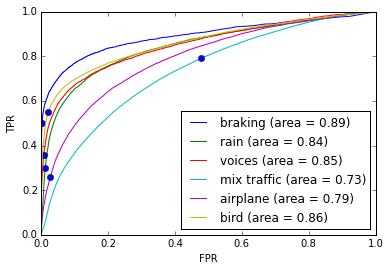

In [19]:
for this_class in results:

    mean_airplane = np.mean([result['normalised_accuracy'] for result in results[this_class]])
#     print mean_airplane

    # now plotting confusion matrix or something...
    all_gt = np.hstack([result['gt'] for result in results[this_class]])
    all_pred = np.hstack([result['pred'] for result in results[this_class]])
    cm = metrics.confusion_matrix(all_gt, all_pred > 0.5)

#     print "gt", cm
#     print "      pred"

    print this_class.ljust(15),
    print "%0.4f" % evaluation.normalised_accuracy(all_gt, all_pred > 0.5)
    evaluation.plot_roc_curve(all_gt, all_pred, this_class)
# for result in results['airplane']:
#     print evaluation.normalised_accuracy(result['gt'], result['pred'] > 0.5)

In [ ]:
plt.figure(figsize=(15, 2))


In [ ]:
plt.figure(figsize=(20, 20))
pltnum = 0
for count, xx in enumerate(results['airplane']):
    if xx['gt'].sum() > 0:
        plt.subplot(20, 1, pltnum)
        plt.plot(xx['gt'])
        plt.plot(xx['pred'])
        plt.ylim(0, 1.1)
        plt.axis('off')
        pltnum += 1

In [ ]:
print all_gt.mean()